<a href="https://colab.research.google.com/github/hhtnghia321/PPCA---project---Group-NNNV/blob/master/fillna_with_PPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Loading the Dataset

In [0]:
import numpy as np
import random
import pandas as pd

In [0]:
oridata_source = 'https://drive.google.com/u/1/uc?id=1iDCKJQbhoIp23YYZSmxRjub2b91TQmzJ&export=download'
dataNA_source = 'https://drive.google.com/u/1/uc?id=1cz7oJ0BJR5rzH1dVTtq2SJPdhxFEYs9o&export=download'
data_fillNA_source = 'https://drive.google.com/u/1/uc?id=1c6AAacF2piMdrvv6ZU5AwIHwXOo7xvJS&export=downloadd'
pos_of_true_values = 'https://drive.google.com/u/1/uc?id=1B7VOB_qM08uRHWLFvhyd9Hq95CN0OcMz&export=download'

In [0]:
names = ['Sample_code_number', 'Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape',
        'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Bare_Nuclei',
        'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses', 'Class']
ori_data = pd.read_csv(oridata_source, names=names, index_col = False, na_values = '?')
ori_data.fillna(round(ori_data.mean()), inplace = True)
mean_ori_data = ori_data.mean()[1:-1]
ori_data = ori_data.drop(columns=['Sample_code_number', 'Class']).values

In [8]:
names_ = ['Index', 'Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape',
        'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Bare_Nuclei',
        'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses']
data = pd.read_csv(data_fillNA_source, index_col = False, names= names_)
data.shape
data = data.iloc[:,1:].values
print(data.shape)

(699, 9)


In [51]:
data_miss = pd.read_csv(dataNA_source,na_values="?")
sum(pd.isna(data_miss).iloc[:,1:].values)

array([50, 50, 50, 50, 50, 64, 50, 50, 50])

* Missing dataset contains 50 missing value each featuer

###Fill na with position matrix

In [0]:
def fillna_with_posmatrix(data_miss, data, pos_ma):
    data_miss = np.array(data_miss)
    data = np.array(data)
    pos_ma = np.array(pos_ma)
    indeces = np.where(pos_ma == True)
    data_miss[indeces] = data[indeces]
    return data_miss

### Probabilistic PPCA function

In [0]:
def PPCA1(data, q, sigma_init = 1, EM = False, pos_na = None): #pos_na là ma trận chứa vị trí của missing value
    N = data.shape[0]  # N row, N t_i
    d = data.shape[1]  # d cột của data
    mean = np.mean(data.T, axis=1) # mean vector
    mean = np.array([mean]).T # chuyển vecto mean về vecto cột
    if EM == False and pos_na == None: #vì MLE không nhận được missing value
      S = (data.T -  mean).dot((data.T -  mean).T) / N # hiệp phương sai sample S
      eig_vals, eig_vecs = np.linalg.eig(S) # hàm riêng và trị riêng của S
      # xếp các trị riêng hàm riêng tương ứng thành các tuple
      eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
      # xếp lại theo thứ tự theo giá trị trị riêng
      eig_pairs.sort() 
      eig_pairs.reverse()
      # tìm MLE cho lambda
      lambda_ = 0
      for i in range(q, d):
        lambda_ += eig_pairs[i][0]
      sigma_ML = 1/(d-q)*lambda_
      # tìm ma trận U_q
      U_q = eig_pairs[0][1]
      for i in range(1, q):
        U_q = np.vstack((U_q, eig_pairs[i][1]))
      U_q = U_q.T
      # tìm ma trận Delta_q
      eig_vals_for_delta = np.array(eig_pairs[0][0])
      for i in range(1, q):
        eig_vals_for_delta = np.append(eig_vals_for_delta, eig_pairs[i][0])
      Delta_q = np.diag((eig_vals_for_delta))
      # tính ma trận W với giả định R = I
      W = np.matrix.round( U_q.dot(  np.sqrt(Delta_q - sigma_ML*np.identity(q)) ), 2 )
    else:
        sigma = sigma_init 
        W = np.random.rand(d, q)
        while True:
            S = (data.T -  mean).dot((data.T -  mean).T) / N # hiệp phương sai sample S
            M = W.T.dot(W) + sigma * np.identity(q)
            M_inv = np.linalg.inv(M)    
            W_ml = S.dot(W).dot(np.linalg.inv(sigma*np.identity(q) + M_inv.dot(W.T).dot(S).dot(W)))
            sigma_ML = (1/d) * np.trace(S - S.dot(W).dot(M_inv).dot(W_ml.T))
            sigma_ML = np.absolute(sigma_ML)
            if abs((sigma - sigma_ML)) <= 0.00000001:
                break
            W = W_ml
            sigma = sigma_ML
            if isinstance(pos_na, list):
                WtW_inv = np.linalg.inv(W.T.dot(W))
                data_hat = W.dot(WtW_inv).dot(W.T).dot(data.T).T #estimate data mới
                data = fillna_with_posmatrix(data, data_hat, pos_na) #chỉ update những vị trí bị thiếu
        R_T = np.linalg.svd(W.T.dot(W))[0]
        W = W.dot(R_T.T)
    return (W, sigma_ML, mean, data)

In [14]:
W_ML = PPCA1(data, 2, EM=True)
W = W_ML[0]
t_n = (W.dot(np.linalg.inv(W.T.dot(W))).dot(W.T).dot(data.T)).T
#t_n = t_n.T
t_n.shape

(699, 9)

In [0]:
ori_data

In [0]:
pos = pd.read_csv(pos_of_true_values, index_col=False)
pos = pos.iloc[:, 1:]
pos.iloc[:, 0]
result_ML = [] 
result_mean = []
for i in range(0, pos.shape[1]):
  error_ML = []
  error_mean = []
  for item in pos.iloc[:, i]:
    error_ML.append((ori_data[item,i] - t_n[item,i])**2)
    error_mean.append((ori_data[item,i] - mean_ori_data[i])**2)
  result_ML.append((sum(error_ML)/50)**0.5)
  result_mean.append((sum(error_mean)/50)**0.5)

print(result_ML)
print(result_mean)


##Compared Calculation between MLE (closed form) and EM algorithm for PCA


In [0]:
%time 
EM = PPCA(data, 3, EM=True)

In [0]:
%time 
MLE = PPCA(data, 3)

##Compare PCA with PPCA (with missing value)
*in this section, we try to illustrate how good EM of PPCA to reconduct missing value

In [16]:
from sklearn.decomposition import  PCA
pca= PCA(2, random_state=2020)
pca.fit(data)
pca_comps = pca.components_ # W.T
pca_data = pd.DataFrame(pca_comps.dot(data.T).T)
pca_data

,0,1
0,4.906789,0.270090
1,13.233329,-5.293174
2,5.545145,-0.061077
3,14.462263,3.551708
4,5.275929,0.262592
...,...,...
694,5.213932,0.187989
695,4.096420,0.326727
696,16.845225,6.307165
697,14.590570,2.496475


In [42]:
data_miss = pd.read_csv(dataNA_source,na_values="?")
pos_na = pd.isna(data_miss).iloc[:,1:].values
data_miss1 = data_miss.iloc[:,1:].values
data_miss_filled = data_miss.fillna(0).iloc[:,1:].values
ppca_miss = PPCA1(data_miss_filled, 2,EM=True,pos_na= pos_na)
ppca_comp_miss = ppca_miss[0].T # W
data_compl = ppca_miss[3]
ppca_data_miss = pd.DataFrame(ppca_comp_miss.dot(data_compl.T - ppca_miss[2]).T)*(-1)
ppca_data_miss[1] = ppca_data_miss[1]*[-1]
ppca_data_miss

,0,1
0,-24.424403,1.110515
1,24.633398,-9.732973
2,-27.883107,-1.196112
3,32.066244,5.584401
4,-22.083418,0.222112
...,...,...
694,-30.116356,-1.172196
695,-36.090979,0.216912
696,44.142067,9.048228
697,29.964809,2.416319


Text(0.5, 1.0, 'Missing PPCA')

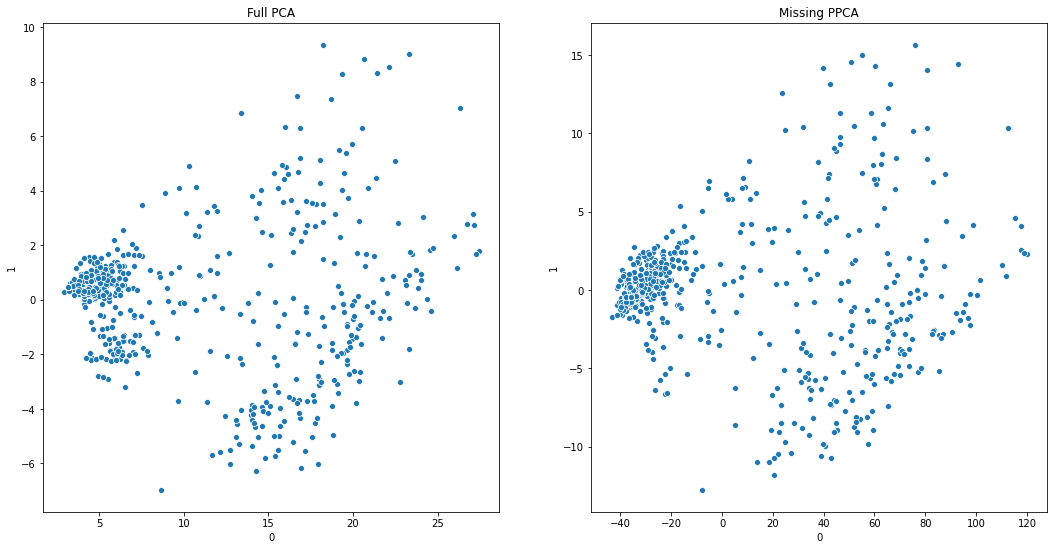

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (18,9))
plt.tight_layout()
plt.subplot(1,2,1)
sns.scatterplot(x = 0, y = 1, data= pca_data, )
plt.title("Full PCA")
plt.subplot(1,2,2)
sns.scatterplot(x = 0, y = 1, data= ppca_data_miss)
plt.title("Missing PPCA")